# **Import necessary libraries**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score

# **Load cifar100 datasets**

In [2]:
(full_train_x, full_train_y), (test_x, test_y) = keras.datasets.cifar100.load_data()
full_train_x.shape, full_train_y.shape, test_x.shape, test_y.shape

169017344/169001437 [==============================] - 3s 0us/step


((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [3]:
np.unique(full_train_y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [4]:
full_train_y[0]

array([19])

# **Create cross-validation set**

In [5]:
train_x, val_x, train_y, val_y = train_test_split(full_train_x, full_train_y, test_size = 0.2)
train_x.shape, val_x.shape, train_y.shape, val_y.shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (40000, 1), (10000, 1))

# **Resize each image to 64 x 64 (for ResNet only)**

In [ ]:
#@title
new_train_x = np.zeros((train_x.shape[0], 64, 64, 3), dtype = np.uint8)
new_val_x = np.zeros((val_x.shape[0], 64, 64, 3), dtype = np.uint8)
new_test_x = np.zeros((test_x.shape[0], 64, 64, 3), dtype = np.uint8)
for i in range(train_x.shape[0]):
  new_train_x[i] = cv2.resize(train_x[i], (64, 64), interpolation = cv2.INTER_CUBIC)
  
for i in range(val_x.shape[0]):
  new_val_x[i] = cv2.resize(val_x[i], (64, 64), interpolation = cv2.INTER_CUBIC)

for i in range(test_x.shape[0]):
  new_test_x[i] = cv2.resize(test_x[i], (64, 64), interpolation = cv2.INTER_CUBIC)

In [ ]:
#@title
train_x, val_x, test_x = new_train_x, new_val_x, new_test_x

# **Normalize data**

In [6]:
train_x.shape, val_x.shape, train_x[0].shape, val_x[0].shape

((40000, 32, 32, 3), (10000, 32, 32, 3), (32, 32, 3), (32, 32, 3))

In [7]:
train_y = keras.utils.to_categorical(train_y)
val_y = keras.utils.to_categorical(val_y)
test_y = keras.utils.to_categorical(test_y)

In [8]:
train_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

# **Labels**

In [9]:
labels = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

# **Data augmentation**

In [10]:
# Train datagen
train_datagen = ImageDataGenerator(
        horizontal_flip = True,
        vertical_flip = True,
        fill_mode = 'nearest',
        featurewise_center = True,
        featurewise_std_normalization = True,
)

train_datagen.fit(train_x)
train_generator = train_datagen.flow(train_x, train_y, batch_size = 64)

# Valid datagen
valid_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
)

valid_datagen.fit(val_x)
valid_generator = valid_datagen.flow(val_x, val_y, batch_size = 64)

# Test datagen
test_datagen = ImageDataGenerator(
    featurewise_center = True,
    featurewise_std_normalization = True,
)

test_datagen.fit(test_x)
test_generator = test_datagen.flow(test_x, test_y, batch_size = 64)

# **Create model**

**Custom model (49.77% on test set)**

In [ ]:
#@title
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, 3, activation = 'relu', input_shape = (64, 64, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, 3, activation = 'relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(32, 5, strides = 2, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Conv2D(64, 3, activation = 'relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, 3, activation = 'relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Conv2D(64, 5, strides = 2, activation = 'relu', padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(512, activation = 'relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(100, activation = 'softmax'))

**ResNet50**

In [ ]:
#@title
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = keras.layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    # Second component of main path
    X = keras.layers.Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    # Third component of main path
    X = keras.layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)

    return X


In [ ]:
#@title Default title text
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = keras.layers.Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = keras.layers.Activation('relu')(X)

    # Second component of main path
    X = keras.layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation('relu')(X)

    # Third component of main path
    X = keras.layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = keras.layers.Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation('relu')(X)
    
    return X

In [ ]:
#@title
def ResNet50(input_shape = (64, 64, 3), classes = 2):   
    # Define the input as a tensor with shape input_shape
    X_input = keras.layers.Input(input_shape)

    # Zero-Padding
    X = keras.layers.ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = keras.layers.Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    X = keras.layers.BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = keras.layers.Activation('relu')(X)
    X = keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL.
    X = keras.layers.AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = keras.layers.Flatten()(X)
    X = keras.layers.Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = keras.initializers.GlorotUniform(seed=0))(X)
    
    # Create model
    model = keras.models.Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [ ]:
#@title
model = ResNet50(input_shape = (64, 64, 3), classes = 100)

**Custom model with 3 CNNs and 1 FC**

In [11]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(128, (3, 3), padding = 'same', input_shape = (32, 32, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(128, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(256, (3, 3), padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(256, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.25))

model.add(keras.layers.Conv2D(512, (3, 3), padding = 'same'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Conv2D(512, (3, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D())
model.add(keras.layers.Dropout(0.4))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(100))
model.add(keras.layers.Activation('softmax'))

# **Model architecture**

In [ ]:
#@title
model.summary()

In [ ]:
#@title
keras.utils.plot_model(model)

# **Compile model**

In [12]:
num_epoch = 100

In [13]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = keras.optimizers.Adam(learning_rate = 1e-4, clipvalue = 0.2),
    metrics = ['accuracy'],
)

# **Train model**

In [14]:
history = model.fit(train_generator, epochs = num_epoch, validation_data = valid_generator, batch_size = 64)

Epoch 1/100
625/625 [==============================] - 87s 87ms/step - loss: 4.3114 - accuracy: 0.0689 - val_loss: 3.7017 - val_accuracy: 0.1372
Epoch 2/100
625/625 [==============================] - 54s 86ms/step - loss: 3.7314 - accuracy: 0.1325 - val_loss: 3.3399 - val_accuracy: 0.1942
Epoch 3/100
625/625 [==============================] - 54s 87ms/step - loss: 3.3937 - accuracy: 0.1865 - val_loss: 3.1013 - val_accuracy: 0.2395
Epoch 4/100
625/625 [==============================] - 54s 87ms/step - loss: 3.1195 - accuracy: 0.2308 - val_loss: 2.8494 - val_accuracy: 0.2894
Epoch 5/100
625/625 [==============================] - 54s 86ms/step - loss: 2.9052 - accuracy: 0.2699 - val_loss: 2.6579 - val_accuracy: 0.3255
Epoch 6/100
625/625 [==============================] - 54s 87ms/step - loss: 2.7338 - accuracy: 0.3031 - val_loss: 2.4831 - val_accuracy: 0.3591
Epoch 7/100
625/625 [==============================] - 54s 87ms/step - loss: 2.6023 - accuracy: 0.3271 - val_loss: 2.4190 - val_ac

# **Plot graph**

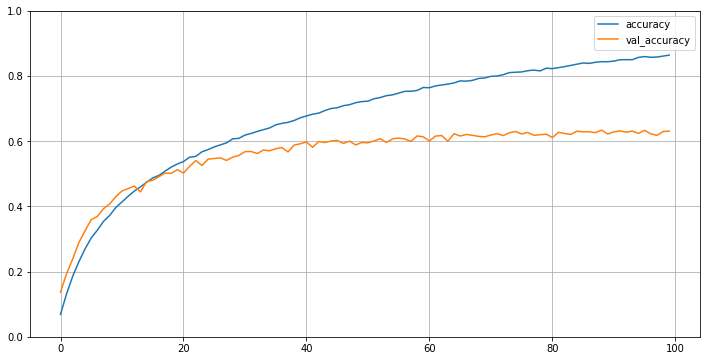

In [15]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize = (12, 6))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

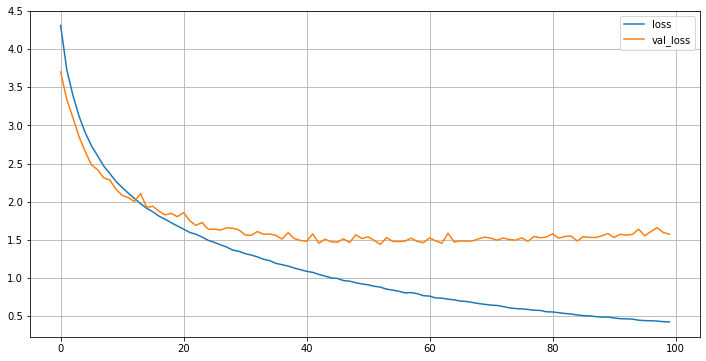

In [16]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize = (12, 6))
plt.grid(True)
plt.show()

# **Evaluate**

In [17]:
model.evaluate(test_generator)

157/157 [==============================] - 4s 24ms/step - loss: 1.5035 - accuracy: 0.6398


[1.5035274028778076, 0.6398000121116638]

In [18]:
pred_y = model.predict(test_generator)

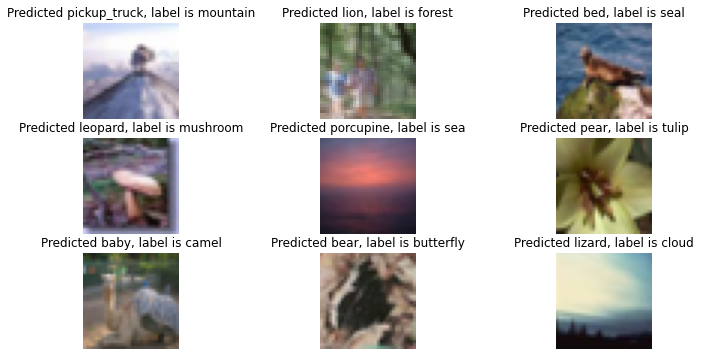

In [20]:
# Analyze 9 cases
plt.figure(figsize = (12, 6))

idx = 0
for i in range(pred_y.shape[0]):
  predicted = np.argmax(pred_y[i])
  true_label = np.argmax(test_y[i])
  if predicted != true_label:
    idx += 1
    plt.subplot(3, 3, idx)
    plt.title(f'Predicted {labels[predicted]}, label is {labels[true_label]}')
    plt.imshow(test_x[i])
    plt.axis('off')

    if idx >= 9:
      break

plt.show()